In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import urllib
import os
import sys
import random
import glob
import re
import time
from io import StringIO
import bs4

%load_ext autoreload
%autoreload 2

sys.path.append("../")
from cleaner import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
docs = glob.glob("../data/raw/*.pdf")

In [24]:
t = docs[0]
t = '../data/raw/transparency_ministerial_January-March_2015.pdf'
t

'../data/raw/transparency_ministerial_January-March_2015.pdf'

In [25]:
from PDFFixup.fixer import *

In [26]:
get_tables(t)

[[[u'The Rt Hon George Osborne MP, Chancellor of the Exchequer '],
  [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
  [u'Nil return ', u' ', u' ', u' '],
  [u'The Rt Hon Danny Alexander MP, Chief Secretary to the Treasury '],
  [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
  [u'Nil return ', u' ', u' ', u' '],
  [u'David Gauke MP, Financial Secretary to the Treasury  '],
  [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
  [u'Nil return  ', u' ', u' ', u' '],
  [u'Priti Patel MP, Exchequer Secretary to the Treasury  '],
  [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
  [u'Nil return  ', u' ', u' ', u' '],
  [u'Andrea Leadsom MP, Economic Secretary to the Treasury '],
  [u'Date gift given ', u'To   ', u'Gift ', u'Value (over \xa3140) '],
  [u'Nil Return ', u' ', u' ', u' '],
  [u'Lord Deighton, Commercial Secretary to the Treasury '],
  [u'Date gift given ', u'To   ', u'Gift ', u'Value (over \xa3140) '],
  [

In [7]:
pages = extract_layout_by_page(t)
page = pages[1]

In [20]:
from collections import defaultdict

texts = []
rects = []
other = []

for e in page:
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect):
        rects.append(e)
    else:
        other.append(e)

# convert text elements to characters
# and rectangles to lines
characters = extract_characters(texts)
lines = [cast_as_line(r) for r in rects
         if width(r) < 2 and
         area(r) > 1]

# match each character to a bounding rectangle where possible
box_char_dict = {}
for c in characters:
    
    # choose the bounding box that occurs the majority of times for each of these:
    bboxes = defaultdict(int)
    l_x, l_y = c.bbox[0], c.bbox[1]
    bbox_l = find_bounding_rectangle((l_x, l_y), lines)
    bboxes[bbox_l] += 1
    
    c_x, c_y = math.floor((c.bbox[0] + c.bbox[2]) / 2), math.floor((c.bbox[1] + c.bbox[3]) / 2)
    bbox_c = find_bounding_rectangle((c_x, c_y), lines)
    bboxes[bbox_c] += 1
    
    u_x, u_y = c.bbox[2], c.bbox[3]
    bbox_u = find_bounding_rectangle((u_x, u_y), lines)
    bboxes[bbox_u] += 1
    
    bbox = max(bboxes.items(), key=lambda x: x[1])[0]
    
    if bbox is None:
        continue

    if bbox in box_char_dict.keys():
        box_char_dict[bbox].append(c)
        continue

    box_char_dict[bbox] = [c]

# look for empty bounding boxes by scanning
# over a grid of values on the page
for x in range(100, 500, 50):
    for y in range(50, 800, 10):
        bbox = find_bounding_rectangle((x, y), lines)

        if bbox is None:
            continue

        if bbox in box_char_dict.keys():
            continue

        box_char_dict[bbox] = []

In [9]:
floating_char = [(k,v) for k,v in box_char_dict.items()
                 if len(v) == 2 and
                 v[0].get_text() == "D"][0]
floating_char

(((66.384, 665.14, 511.32, 679.42), 2),
 [<LTChar 139.332,665.740,147.996,676.996 matrix=[1.00,0.00,0.00,1.00, (139.33,668.26)] font='ABCDEE+Arial,Bold' adv=8.664 text=u'D'>,
  <LTChar 392.592,665.740,399.924,676.996 matrix=[1.00,0.00,0.00,1.00, (392.59,668.26)] font='ABCDEE+Arial,Bold' adv=7.332 text=u'T'>])

In [10]:
unfloating = [(k,v) for k,v in box_char_dict.items()
                 if k[1] == sorted([b[1] for b in box_char_dict.keys()], reverse=True)[11]][0]

In [12]:
print floating_char[1][0].bbox
print unfloating

(139.332, 665.74, 147.99599999999998, 676.996)
((66.384, 665.14, 511.32, 679.42), [])


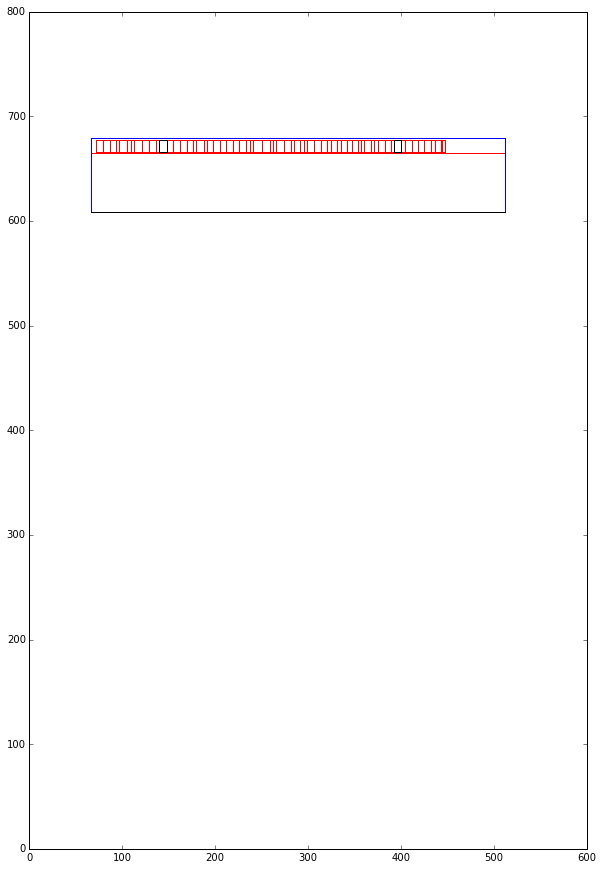

In [45]:
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)
    
def draw_rect_bbox((x0,y0,x1,y1), ax, color):
    ax.add_patch( 
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )    
    )
    

from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

draw_rect_bbox(unfloating[0], ax, "r")
for c in unfloating[1]:
    draw_rect(c, ax, "r")

draw_rect_bbox(floating_char[0], ax, "b")
for c in floating_char[1]:
    draw_rect(c, ax, "k")

x0,y0,x1,y1,_ = (66.864, 608.38, 511.32399999999996, 608.38, 'H')
plt.plot([x0, x1], [y0, y1], 'k-')
    
plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [46]:
unfloating[0]

(66.384, 665.14, 511.32, 679.42)

In [47]:
[l for l in lines if l[1] == 665.14]

[(66.864, 665.14, 142.704, 665.14, 'H'),
 (143.18, 665.14, 229.00400000000002, 665.14, 'H'),
 (229.49, 665.14, 326.954, 665.14, 'H'),
 (327.43, 665.14, 395.85400000000004, 665.14, 'H'),
 (396.34, 665.14, 511.32, 665.14, 'H')]